<a href="https://colab.research.google.com/github/ikonthomas/SchoolPlay/blob/master/WQU_MScFE_MachineLearningInFinance_Project_Submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Initializing parameters
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

In [0]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import datetime as dt
from tqdm import tqdm_notebook as tqdm

In [0]:
# Data location
data = 'data/ES_Trades.csv'
raw_data = pd.read_csv(data)

In [0]:
# Bar details
cols = {'Timestamp': 'Tick Timestamp', 
        'VWAP': 'Volume Weighted Average Price', 
        'Open': 'Open Price', 
        'Close': 'Close Price', 
        'High': 'High Price', 
        'Low': 'Low Price', 
        'Volume': 'Shares Traded'}

In [0]:
def make_data_bar(tick_data: pd.DataFrame):
    '''
    Method to create an information bar from the tick_data
    '''
    if 'Time' in tick_data:
        bar_timestamp = dt.datetime.strptime(f"{tick_data['Date'].iloc[0]} {tick_data['Time'].iloc[0]}", 
                                             "%m/%d/%Y %H:%M:%S.%f")
    else:
        try:
            bar_timestamp = dt.datetime.strptime(f"{tick_data['Date'].iloc[0]}", "%Y-%m-%d")
        except IndexError:
            # print(tick_data['Date'])
            return None
    
    bar_volume = tick_data['Volume'].sum()
    bar_open = tick_data['Price'].iloc[0]
    bar_low = tick_data['Price'].min()
    bar_high = tick_data['Price'].max()
    bar_close = tick_data['Price'].iloc[-1]
    bar_vwap = tick_data['Volume'].dot(tick_data['Price'])/bar_volume

    return [bar_timestamp, bar_vwap, bar_open, bar_close, bar_high, bar_low, bar_volume]

In [0]:
def make_time_bars(raw_data: pd.DataFrame, sample_duration=60) -> pd.DataFrame:
    '''
    Method to create Time Bars
    '''
    row_count = len(raw_data)
    idx_ranges: [(int, int)] = None
    duration = dt.timedelta(seconds=sample_duration)
    time_ticks = raw_data.loc[:,['Date','Time']]
    time_ticks['Timestamp'] = time_ticks['Date'] + ' ' + time_ticks['Time']
    time_ticks = pd.to_datetime(time_ticks['Timestamp'], format='%m/%d/%Y %H:%M:%S.%f')
    start_time = time_ticks[0]
    end_time = start_time + duration
    idx_ranges = []
    l_idx = 0
    r_idx = 0
    tmp = start_time
    with tqdm(total=row_count, desc='Creating indexes:') as pbar:
        for i, x in enumerate(time_ticks):
            r_idx = i
            if x > end_time:
                idx_ranges.append((l_idx, r_idx))
                end_time = tmp + duration
                l_idx = r_idx
            tmp = x
            pbar.update(1)
    
    tb_table = pd.DataFrame(index=np.arange(0, len(idx_ranges)), columns=cols.keys())
    
    with tqdm(total=len(idx_ranges), desc='Creating bars:') as pbar:
        tb_table_idx = 0
        for l_idx, r_idx in idx_ranges:
            tb_table.loc[tb_table_idx] = make_data_bar(raw_data.iloc[l_idx:r_idx,:])
            tb_table_idx += 1
            
            # update status bar
            pbar.update(1)
        
    
    return tb_table 

In [0]:
def make_tick_bars(raw_data: pd.DataFrame, sample_size) -> pd.DataFrame:  
    '''
    Method to create tick bars
    '''
    tb_table = pd.DataFrame(index=np.arange(0, int(len(raw_data)/sample_size)), columns=cols.keys())
    row_count = len(raw_data)
    idx_ranges: [(int, int)] = list(
        zip(
            np.arange(0, row_count, sample_size), 
            np.arange(sample_size, row_count + sample_size, sample_size)
        ))
    
    with tqdm(total=row_count, desc='Creating tick bars:') as pbar:
        for l_idx, r in idx_ranges:
            tb_table_idx = int(l_idx/sample_size)
            r_idx = min(r, row_count)
            tb_table.loc[tb_table_idx] = make_data_bar(raw_data.iloc[l_idx:r_idx,:])

            # update status bar
            pbar.update(sample_size)

    return tb_table 

In [0]:
def make_volume_bars(raw_data: pd.DataFrame, volume_size=100000) -> pd.DataFrame:
    '''
    Method to create Volume Bars
    '''
    # Create the index ranges
    row_count = len(raw_data)
    vol_data = raw_data['Volume']
    idx_ranges = []
    cum_total = 0
    l = 0
    r = 0
    with tqdm(total=row_count, desc='Calculating indices') as pbar:
        for i, vol in enumerate(vol_data):
            cum_total += vol
            if cum_total > volume_size:
                r = i
                idx_ranges.append((l, r))
                cum_total = vol
                l = r
            if i == row_count - 1:
                idx_ranges.append((l, i))
            
            # update status bar
            pbar.update(1)
    
    tb_table = pd.DataFrame(index=np.arange(0, len(idx_ranges)), columns=cols.keys())
    
    with tqdm(total=len(idx_ranges), desc='Creating bars') as pbar:
        tb_table_idx = 0
        for l_idx, r_idx in idx_ranges:
            data_bar = make_data_bar(raw_data.iloc[l_idx:r_idx,:])
            if data_bar is not None:
                tb_table.loc[tb_table_idx] = data_bar
            tb_table_idx += 1
            
            # update status bar
            pbar.update(1)
        
    return tb_table 

In [0]:
def make_dollar_bars(raw_data: pd.DataFrame, market_value=100000) -> pd.DataFrame:
    '''
    Method to create Dollar Bars
    '''
    # Create the index ranges
    row_count = len(raw_data)
    mv_data = raw_data['Volume']*raw_data['Price']
    idx_ranges = []
    cum_total = 0
    l = 0
    r = 0
    with tqdm(total=row_count, desc='Calculating indexes') as pbar:
        for i, mv in enumerate(mv_data):
            cum_total += mv
            if cum_total > market_value:
                r = i
                idx_ranges.append((l, r))
                cum_total = mv
                l = r
            if i == row_count - 1:
                idx_ranges.append((l, i))
            
            # update status bar
            pbar.update(1)
    
    tb_table = pd.DataFrame(index=np.arange(0, len(idx_ranges)), columns=cols.keys())
    
    with tqdm(total=len(idx_ranges), desc='Creating bars') as pbar:
        tb_table_idx = 0
        for l_idx, r_idx in idx_ranges:
            tb_table.loc[tb_table_idx] = make_data_bar(raw_data.iloc[l_idx:r_idx,:])
            tb_table_idx += 1
            
            # update status bar
            pbar.update(1)
        
    return tb_table

In [0]:
def plot_bar_details(bar_data:pd.DataFrame, color:str, title:str):
    with plt.style.context("ggplot"):    
        fig = plt.figure(figsize=(15,5))
        layout = (1, 3)
        counts_ax = plt.subplot2grid(layout, (0, 0))
        bar_plot_ax = plt.subplot2grid(layout, (0, 1), colspan=2)
        
        # Analyze the time bar data by analyzing the distribution
        bar_data['WOY'] = bar_data['Timestamp'].dt.week
        bars_weekly_counts = bar_data.loc[:,['WOY','Close']].groupby(['WOY']).count()
        counts_ax.set_title(f"Bar Count - {title}")
        counts_ax.bar(bars_weekly_counts.index.values, bars_weekly_counts['Close'].values, color=color, alpha=0.5)
        
        bar_plot_ax.set_title(title)
        bars_plot_df = bar_data.loc[:,['Close']]
        plt.plot(bars_plot_df['Close'].values, c=color, lw=0.75, alpha=0.75)
        plt.tight_layout()

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Creating Time Bars</strong></p>
</div>

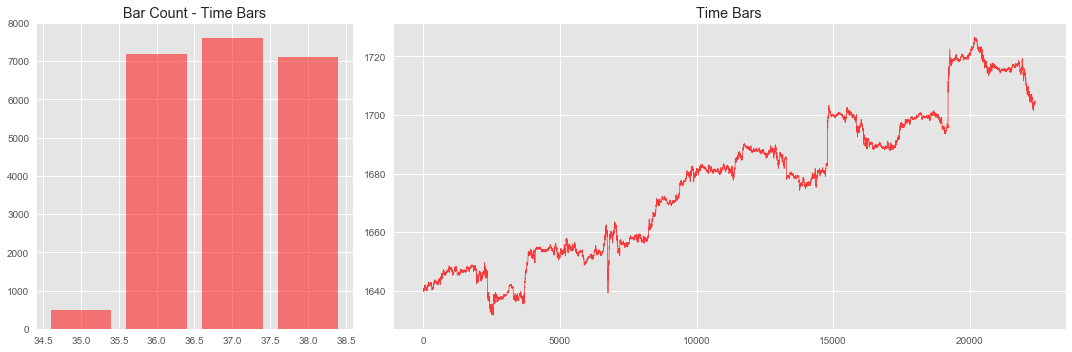

In [0]:
# Make the Time Bars 
time_bars = make_time_bars(raw_data)

# Plot the Time Bars
plot_bar_details(time_bars, color='r', title='Time Bars')

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Creating Tick Bars</strong></p>
</div>

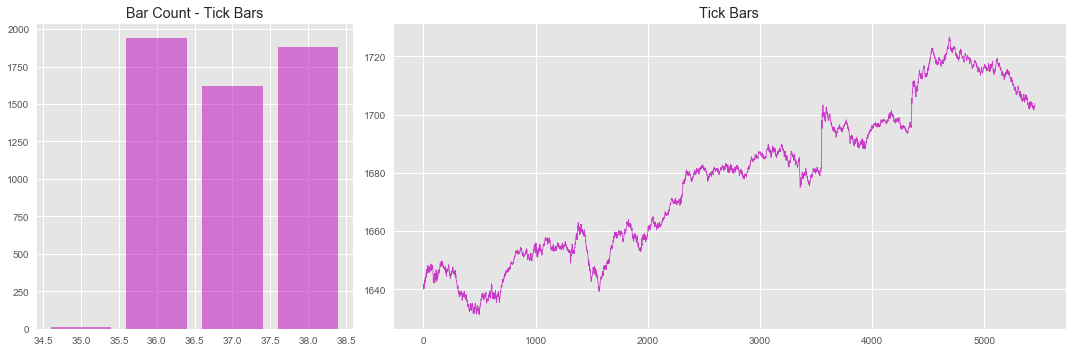

In [0]:
# Make the tick bars
tick_bars = make_tick_bars(raw_data, sample_size=1000)

# Plot the Tick Bars
plot_bar_details(tick_bars, color='m', title='Tick Bars')

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Creating Volume Bars</strong></p>
</div>

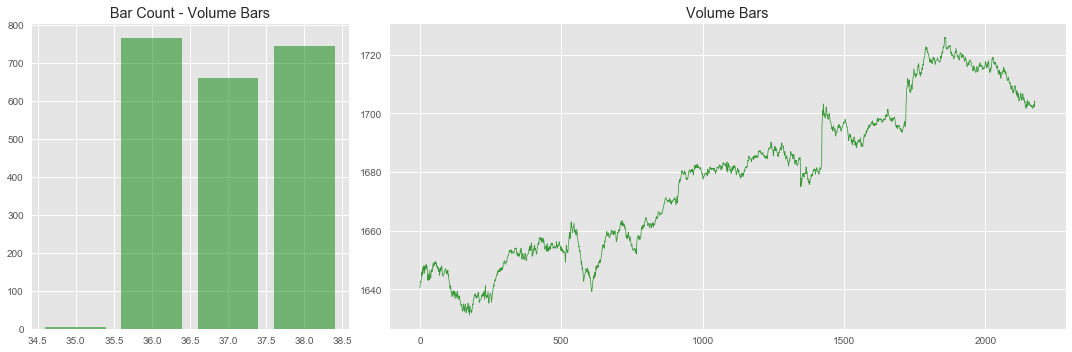

In [0]:
# Make the Volume Bars
volume_bars = make_volume_bars(raw_data, volume_size=10000)

# Plot the Volume Bars
plot_bar_details(volume_bars, color='g', title='Volume Bars')

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Creating Dollar Bars</strong></p>
</div>

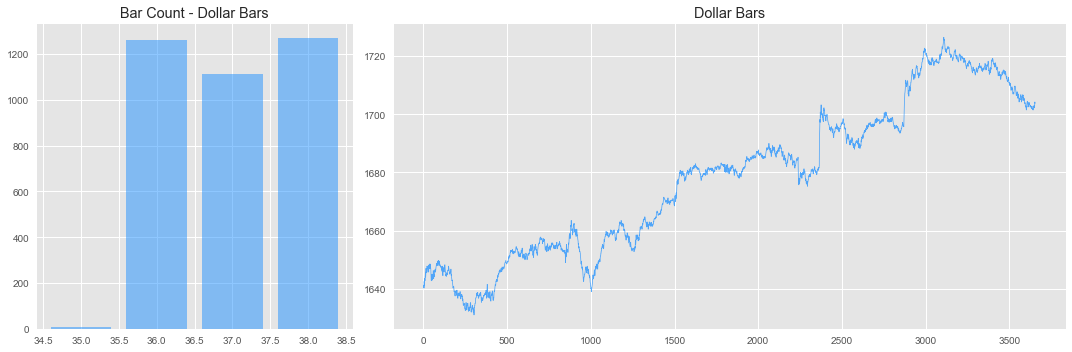

In [0]:
# Make Dollar Bars
dollar_bars = make_dollar_bars(raw_data, market_value=10000000)

# Plot the Dollar Bars
plot_bar_details(dollar_bars, color='dodgerblue', title='Dollar Bars')

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Comparing bar counts</strong></p>
</div>

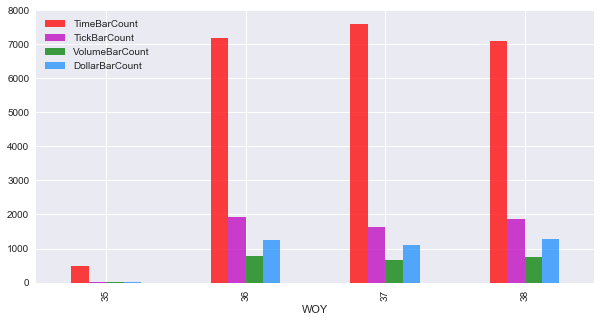

In [0]:
bar_count_data = pd.DataFrame()
bar_count_data['TimeBarCount'] = time_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()['Close']
bar_count_data['TickBarCount'] = tick_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
bar_count_data['VolumeBarCount'] = volume_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
bar_count_data['DollarBarCount'] = dollar_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
bar_count_data.plot(kind='bar', figsize=[10,5], color=('r', 'm', 'g', 'dodgerblue'), alpha=0.75)

---

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Calculating serial correlations of each bar type</strong></p>
</div>

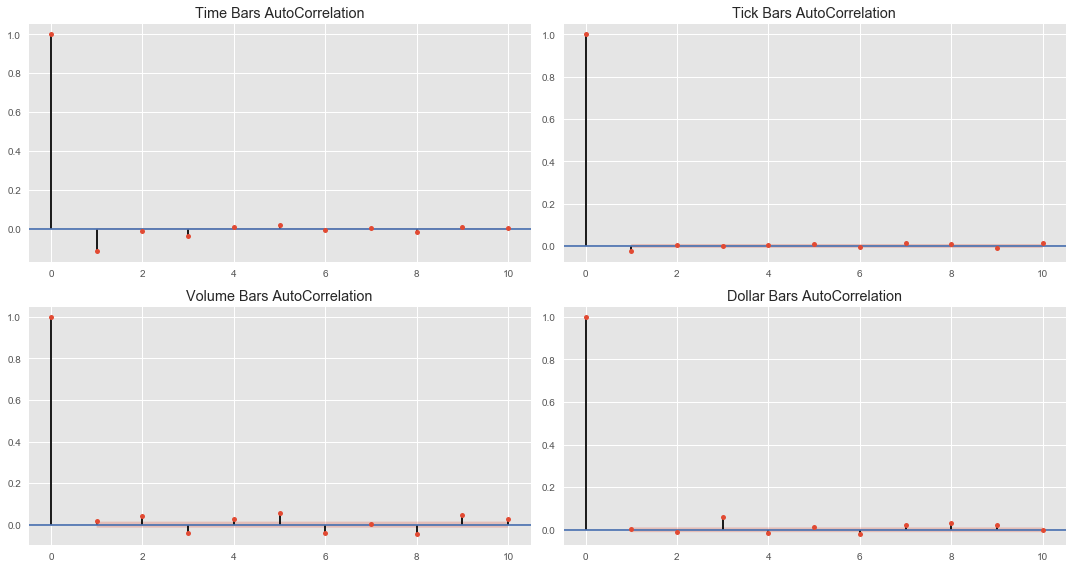

In [0]:
time_returns = np.log(time_bars['Close'].astype(np.float64)).diff().dropna()
tick_returns = np.log(tick_bars['Close'].astype(np.float64)).diff().dropna()
volume_returns = np.log(volume_bars['Close'].astype(np.float64)).diff().dropna()
dollar_returns = np.log(dollar_bars['Close'].astype(np.float64)).diff().dropna()

with plt.style.context("ggplot"): 
    fig = plt.figure(figsize=(15, 8))
    layout = (2, 2)
    
    time_ax = plt.subplot2grid(layout, (0, 0))
    tick_ax = plt.subplot2grid(layout, (0, 1))
    volume_ax = plt.subplot2grid(layout, (1, 0))
    dollar_ax = plt.subplot2grid(layout, (1, 1))

    plot_acf(time_returns, lags=10, ax=time_ax, alpha=0.5, title='Time Bars AutoCorrelation')
    plot_acf(tick_returns, lags=10, ax=tick_ax, alpha=0.5, title='Tick Bars AutoCorrelation')
    plot_acf(volume_returns, lags=10, ax=volume_ax, alpha=0.5, title='Volume Bars AutoCorrelation')
    plot_acf(dollar_returns, lags=10, ax=dollar_ax, alpha=0.5, title='Dollar Bars AutoCorrelation')

    plt.tight_layout()

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Applying Jarque-Bera normality test on the returns</strong></p>
</div>

In [0]:
print('Time:', '\t\t', int(stats.jarque_bera(time_returns)[0]))
print('Tick:', '\t\t', int(stats.jarque_bera(tick_returns)[0]))
print('Volume:', '\t', int(stats.jarque_bera(volume_returns)[0]))
print('Dollar:', '\t', int(stats.jarque_bera(dollar_returns)[0]))

Time: 		 71995895
Tick: 		 591154
Volume: 	 49945
Dollar: 	 78630


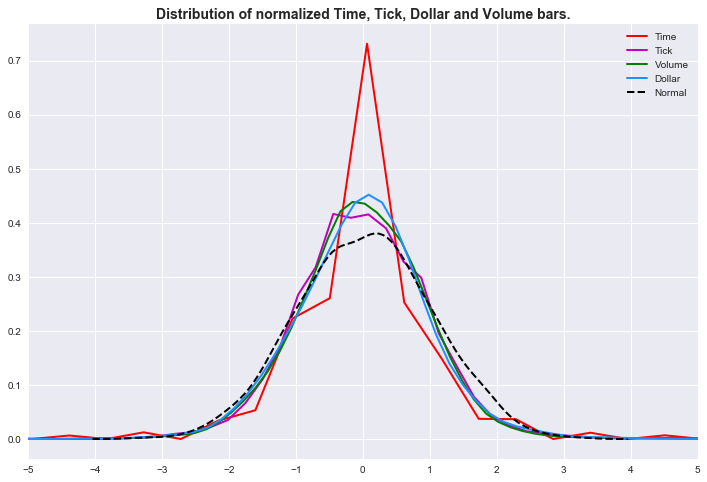

In [0]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(12,8))
seaborn.kdeplot(time_standard, label="Time", bw=0.25, color='red', lw=2)
seaborn.kdeplot(tick_standard, label="Tick", bw=0.25, color='m', lw=2)
seaborn.kdeplot(volume_standard, label="Volume", bw=0.25, color='green', lw=2)
seaborn.kdeplot(dollar_standard, label="Dollar", bw=0.25, color='dodgerblue', lw=2)

seaborn.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--", lw=2)

plt.xticks(range(-5, 6))
plt.legend()
plt.title('Distribution of normalized Time, Tick, Dollar and Volume bars.', fontsize=14, fontweight="bold")
plt.xlim(-5, 5)
plt.show()

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Analyzing historical price data downloaded from Yahoo</strong></p>
    <p><strong>iShares Core S&P 500 ETF (IVV)</strong></p>
</div>

In [0]:
from yahoo_historical import Fetcher

In [0]:
stock_ticker = "IVV"
stock_prices = Fetcher(stock_ticker, [2000,1,1], [2019,4,18])
hist_stock_data = stock_prices.getHistorical()
hist_stock_data['Price'] = hist_stock_data['Close']

In [0]:
hist_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Price
0,2000-05-19,142.65625,142.65625,140.25000,140.68750,98.412659,775500,140.68750
1,2000-05-22,140.59375,140.59375,136.81250,139.81250,97.800583,1850600,139.81250
2,2000-05-23,140.21875,140.21875,137.68750,137.68750,96.314117,373900,137.68750
3,2000-05-24,137.75000,140.06250,136.65625,139.75000,97.756912,400300,139.75000
4,2000-05-25,140.03125,140.93750,137.87500,138.46875,96.860619,69600,138.46875


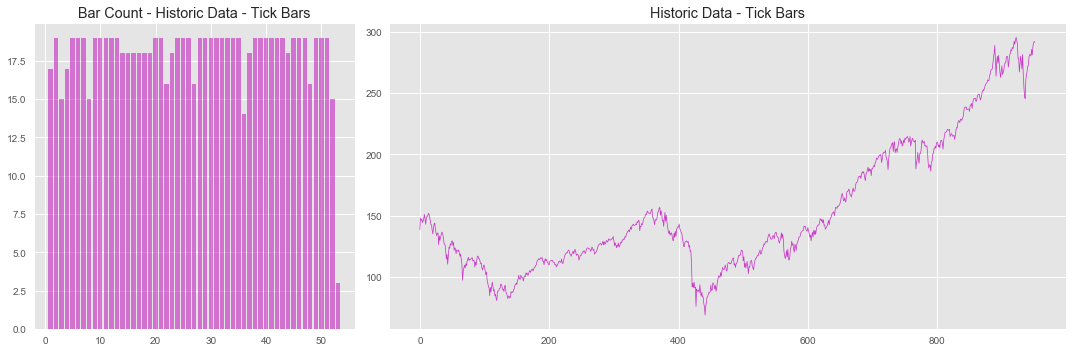

In [0]:
# Make the tick bars
hist_data_tick_bars = make_tick_bars(hist_stock_data, sample_size=5)

# Plot the Tick Bars
plot_bar_details(hist_data_tick_bars, color='m', title='Historic Data - Tick Bars')

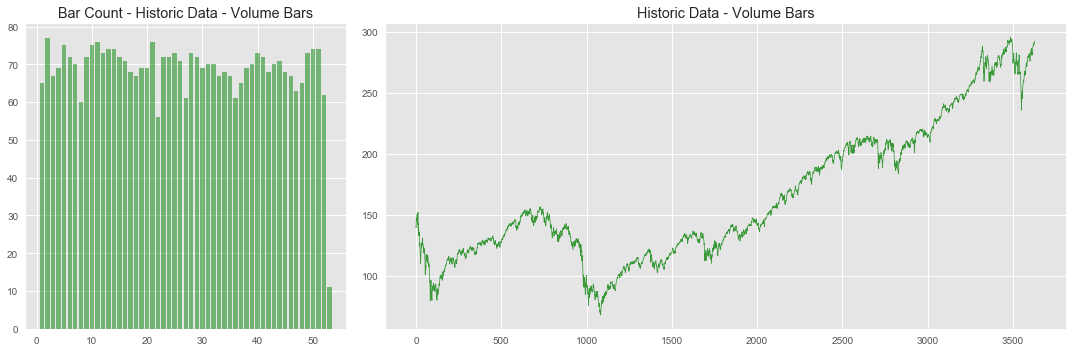

In [0]:
# Make the Volume Bars
hist_data_volume_bars = make_volume_bars(hist_stock_data, volume_size=2000000)

# Plot the Volume Bars
plot_bar_details(hist_data_volume_bars, color='g', title='Historic Data - Volume Bars')

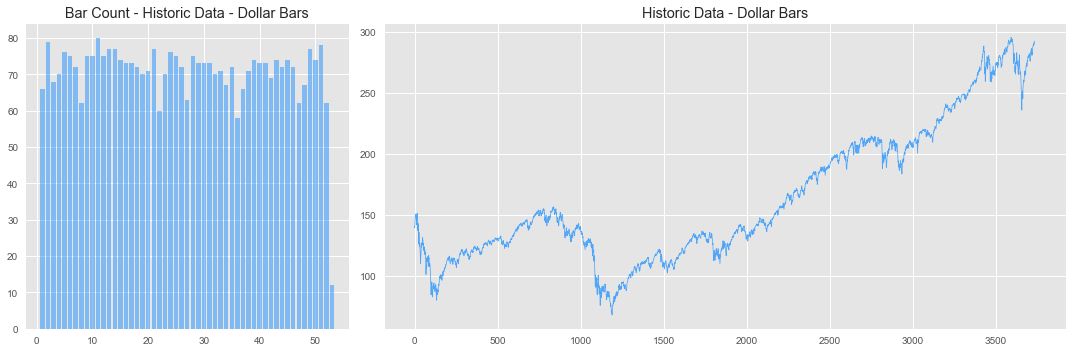

In [0]:
# Make Dollar Bars
hist_data_dollar_bars = make_dollar_bars(hist_stock_data, market_value=200000000)

# Plot the Dollar Bars
plot_bar_details(hist_data_dollar_bars, color='dodgerblue', title='Historic Data - Dollar Bars')

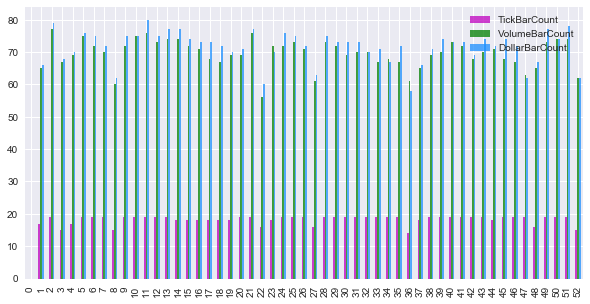

In [0]:
hist_data_bar_counts = pd.DataFrame()
hist_data_bar_counts['TickBarCount'] = hist_data_tick_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
hist_data_bar_counts['VolumeBarCount'] = hist_data_volume_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
hist_data_bar_counts['DollarBarCount'] = hist_data_dollar_bars.loc[:,['WOY','Close']].groupby(['WOY']).count()
hist_data_bar_counts.plot(kind='bar', figsize=[10,5], color=('m', 'g', 'dodgerblue'), alpha=0.75)

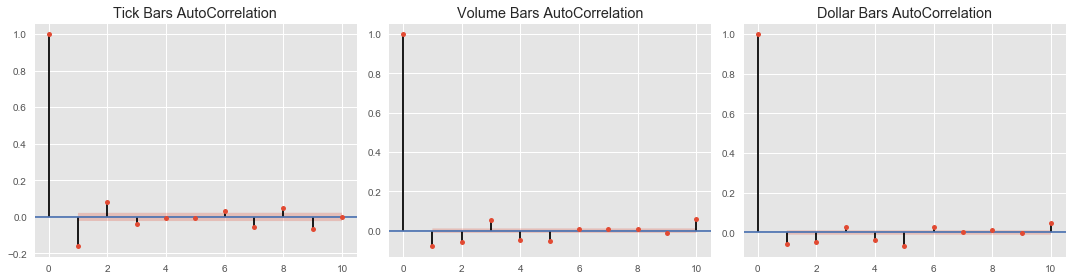

In [0]:
hist_data_tick_returns = np.log(hist_data_tick_bars['Close'].astype(np.float64)).diff().dropna()
hist_data_volume_returns = np.log(hist_data_volume_bars['Close'].astype(np.float64)).diff().dropna()
hist_data_dollar_returns = np.log(hist_data_dollar_bars['Close'].astype(np.float64)).diff().dropna()

with plt.style.context("ggplot"): 
    fig = plt.figure(figsize=(15, 4))
    layout = (1, 3)
    
    tick_ax = plt.subplot2grid(layout, (0, 0))
    volume_ax = plt.subplot2grid(layout, (0, 1))
    dollar_ax = plt.subplot2grid(layout, (0, 2))

    plot_acf(hist_data_tick_returns, lags=10, ax=tick_ax, alpha=0.5, title='Tick Bars AutoCorrelation')
    plot_acf(hist_data_volume_returns, lags=10, ax=volume_ax, alpha=0.5, title='Volume Bars AutoCorrelation')
    plot_acf(hist_data_dollar_returns, lags=10, ax=dollar_ax, alpha=0.5, title='Dollar Bars AutoCorrelation')

    plt.tight_layout()

<div style="background-color:#C7C7C7;padding-left:10px;padding-top:10px;">
    <p class="lead"><strong>Applying Jarque-Bera normality test on the historical data returns</strong></p>
</div>

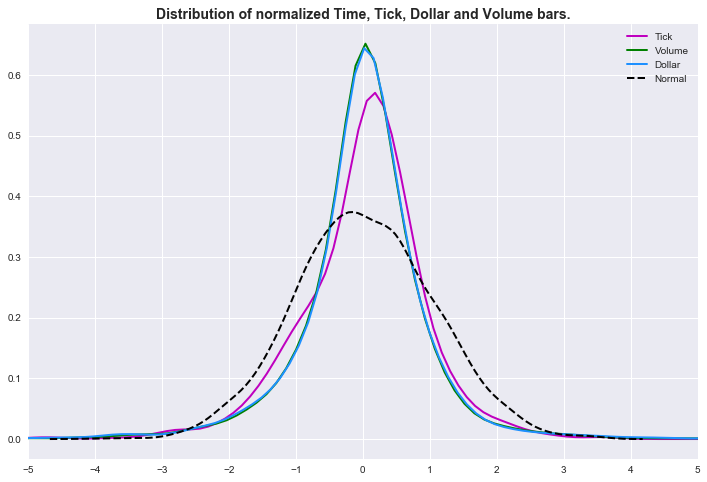

In [0]:
# Calculate the differences
tick_diff = hist_data_tick_returns
volume_diff = hist_data_volume_returns
dollar_diff = hist_data_dollar_returns

# Standardize the data
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(12,8))
seaborn.kdeplot(tick_standard, label="Tick", bw=0.25, color='m', lw=2)
seaborn.kdeplot(volume_standard, label="Volume", bw=0.25, color='green', lw=2)
seaborn.kdeplot(dollar_standard, label="Dollar", bw=0.25, color='dodgerblue', lw=2)

seaborn.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--", lw=2)

plt.xticks(range(-5, 6))
plt.legend()
plt.title('Distribution of normalized Time, Tick, Dollar and Volume bars.', fontsize=14, fontweight="bold")
plt.xlim(-5, 5)
plt.show()